In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Concat_2 as chase_xgb_tune

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder
### LCCDATA files saved in lccdata_folder

In [2]:
# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'
prmtop_2 = 'myc_091-160_D132-H_stripped.prmtop'
nc_2 = 'aMD_091-160_D132-H_no1-4_stripped.nc'
protein_length = 70
window_range = range(2, 52)

# Setup folders and execute scripts
cpptraj_folder, lccdata_folder, should_proceed = chase_lcc.setup_folders()
if should_proceed:
    chase_lcc.execute_cpptraj_scripts(prmtop_1, nc_1, prmtop_2, nc_2, protein_length, window_range, cpptraj_folder, lccdata_folder)
else:
    print("No need to regenerate cpptraj scripts or lccdata files.")

cpptraj files and lccdata_files already generated.
No need to regenerate cpptraj scripts or lccdata files.


In [3]:
# Create LCCDATA files
chase_lcc.execute_cpptraj_commands(cpptraj_folder, window_range)

cpptraj files and lccdata_files already generated.


# Load LCCDATA and attach to variables wt_dict[window] and D132H_dict[window]

In [4]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Create Local Compaction Plots

In [5]:
save_folder = 'Local_Compaction_Plot_Figures'
if not (os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50):
    for window in window_range:
        chase_lcc.LCC_plot_individual(window, wt_dict[window], D132H_dict[window], save_folder)
else:
    print("Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'")

Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'


## Concatenate and save data:

In [6]:
chase_xgb_tune.concat_and_save_dataframes(wt_dict, 'wt_concat.csv')
chase_xgb_tune.concat_and_save_dataframes(D132H_dict, 'D132H_concat.csv')

Concatenated files already generated.
Concatenated files already generated.


In [7]:
concat_folder = 'concatenated_data'

wt_concat_path = f"{concat_folder}/wt_concat.csv"
D132H_concat_path = f"{concat_folder}/D132H_concat.csv"

wt_concat = pd.read_csv(wt_concat_path, index_col=0)
D132H_concat = pd.read_csv(D132H_concat_path, index_col=0)

# Feature Engineering:

#### XGBoost Hyperparameter Evaluation
- Pre-prepares data
- Runs XGBoost on each window size with default hyperparameters
- Performs XGBoost hyperparameter tuning
- Generates figures to compare the performance of hyperparameters

### Extracting Feature Importances

In [8]:
hyperparameters = {'max_depth': 9, 'eta': 0.2, 'subsample': 0.9, 'colsample_bytree': 0.8, 'verbosity':1}
manual_hyperparameters = {'max_depth': 9, 'eta': 0.2, 'subsample': 0.9, 'colsample_bytree': 0.8, 'verbosity':1}

trainer = chase_xgb_tune.XGBoostTrainer(wt_concat, D132H_concat, hyperparameters)
trainer.train_model_and_evaluate()

# Specify the base feature importance threshold
importance_threshold = 0.002

# Save important features with adjusted thresholds for each window size
trainer.save_important_features_and_plot(importance_threshold, manual_hyperparameters)

[0]	train-rmse:0.40951	test-rmse:0.42930
[1]	train-rmse:0.34345	test-rmse:0.38179
[2]	train-rmse:0.29020	test-rmse:0.35283
[3]	train-rmse:0.24218	test-rmse:0.31977
[4]	train-rmse:0.20288	test-rmse:0.29690
[5]	train-rmse:0.17373	test-rmse:0.27929
[6]	train-rmse:0.14716	test-rmse:0.26779
[7]	train-rmse:0.12643	test-rmse:0.25610
[8]	train-rmse:0.10857	test-rmse:0.25141
[9]	train-rmse:0.09365	test-rmse:0.24471
[10]	train-rmse:0.08114	test-rmse:0.24048
[11]	train-rmse:0.07149	test-rmse:0.23837
[12]	train-rmse:0.06253	test-rmse:0.23542
[13]	train-rmse:0.05441	test-rmse:0.23256
[14]	train-rmse:0.04726	test-rmse:0.22946
[15]	train-rmse:0.04223	test-rmse:0.22826
[16]	train-rmse:0.03759	test-rmse:0.22774
[17]	train-rmse:0.03307	test-rmse:0.22611
[18]	train-rmse:0.02968	test-rmse:0.22515
[19]	train-rmse:0.02757	test-rmse:0.22433
[20]	train-rmse:0.02470	test-rmse:0.22316
[21]	train-rmse:0.02231	test-rmse:0.22248
[22]	train-rmse:0.02101	test-rmse:0.22226
[23]	train-rmse:0.01926	test-rmse:0.22205
[2

KeyError: "None of [Index([None, None, None, None, None, None, None, None, None, None,\n       ...\n       None, None, None, None, None, None, None, None, None, None],\n      dtype='object', length=137)] are in the [columns]"

### Position importance for each window size

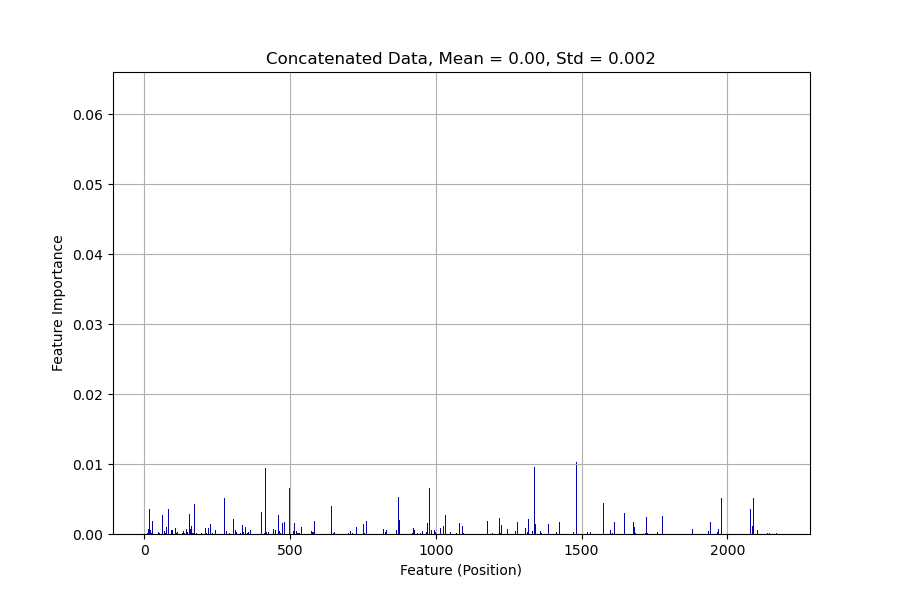

In [9]:
# Display the saved feature importance plots in the notebook
trainer.display_feature_importance_plots('XGB_Pos_Imp_Figs')

## De-Concatenate Data to Position Importance Values For Each Window Size

In [10]:
# Define paths
input_file_path = 'XGB_Position_Importance_Values/feature_importances_concatenated.csv'
output_folder_path = 'XGB_Position_Importance_Deconcat'

# Ensure output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Read the concatenated feature importance values
df = pd.read_csv(input_file_path)

# Initial positions
start_pos = 0

for window_size in range(2, 52):
    # Calculate the number of positions for this window size (decreasing by 1 for each window)
    num_positions = 70 - window_size
    
    # Calculate start and end positions for slicing
    end_pos = start_pos + num_positions
    
    # Slice the dataframe for the current window size
    sliced_df = df.iloc[start_pos:end_pos].copy()
    
    # Renumber positions starting from 1
    sliced_df['Position'] = range(1, num_positions + 1)
    
    # Generate output file name
    output_file_name = f'feature_imp_deconcatenated_{window_size}.csv'
    output_file_path = os.path.join(output_folder_path, output_file_name)
    
    # Save to CSV
    sliced_df.to_csv(output_file_path, index=False)
    
    # Update start_pos for the next iteration
    start_pos = end_pos

print("De-concatenation process completed.")


De-concatenation process completed.


## Compare Multiples to Match Deconcatenated Importance Values to Unconcatenated

- Window size position variation
    - (70-window_size)/68
- Number of positions:
    - Sum of importances = 1
    - Multiply deconcatenated importances by 50
- Tuning accuracy for unconcat:
    - XGB_Tuning/XGB_Tuning_Trial_1/tuning_results.json

# RMSE

## Graphical representation of feature importances

In [11]:
# Create the output directory if it doesn't exist
output_dir = "Overlaid_Importance"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

folder_path_1 = 'XGB_Position_Importance_Deconcat'
folder_path_2 = 'XGB_Position_Importance_Values2'
    
def adjust_and_plot(window_size):
    # Construct file paths
    unconcatenated_file = f"XGB_Position_Importance_Values2/feature_importances_window_{window_size}.csv"
    deconcatenated_file = f"XGB_Position_Importance_Deconcat/feature_imp_deconcatenated_{window_size}.csv"
    
    # Read the CSV Files
    df10 = pd.read_csv(unconcatenated_file)
    df20 = pd.read_csv(deconcatenated_file)
    
    # Assuming the positions are in the first column and importances in the second
    position_col = df10.columns[0]
    importance_col = df10.columns[1]
    
    # Multiply importance values in df1 by adjustment factor
    df20[importance_col] = df20[importance_col] * 50
    df20[importance_col] = df20[importance_col] * ((70 - window_size)/68)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(df10['Position'], df10['Importance'], color='blue', label='Unconcatenated', alpha=0.3)
    plt.bar(df20['Position'], df20['Importance'], color='red', label='Deconcatenated', alpha=0.3)
    plt.title(f'Position Importance Values for Window Size {window_size}')
    plt.xlabel('Position')
    plt.ylabel('Importance')
    plt.legend()
    plt.savefig(f"Overlaid_Importance/Overlaid_Importance_{window_size}.png")
    plt.close()

# Loop through all window sizes
for window_size in range(2, 51):
    adjust_and_plot(window_size)

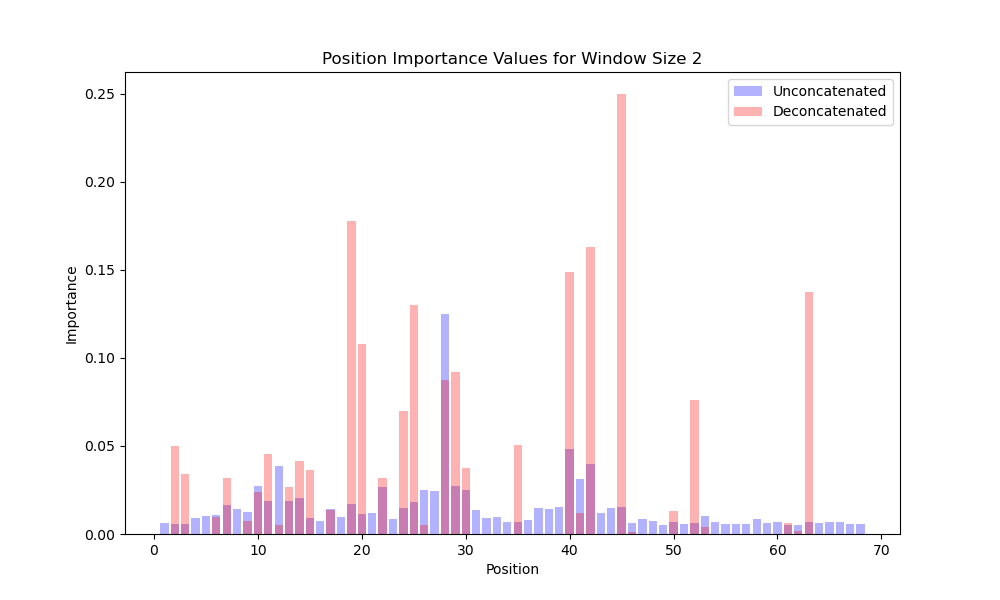

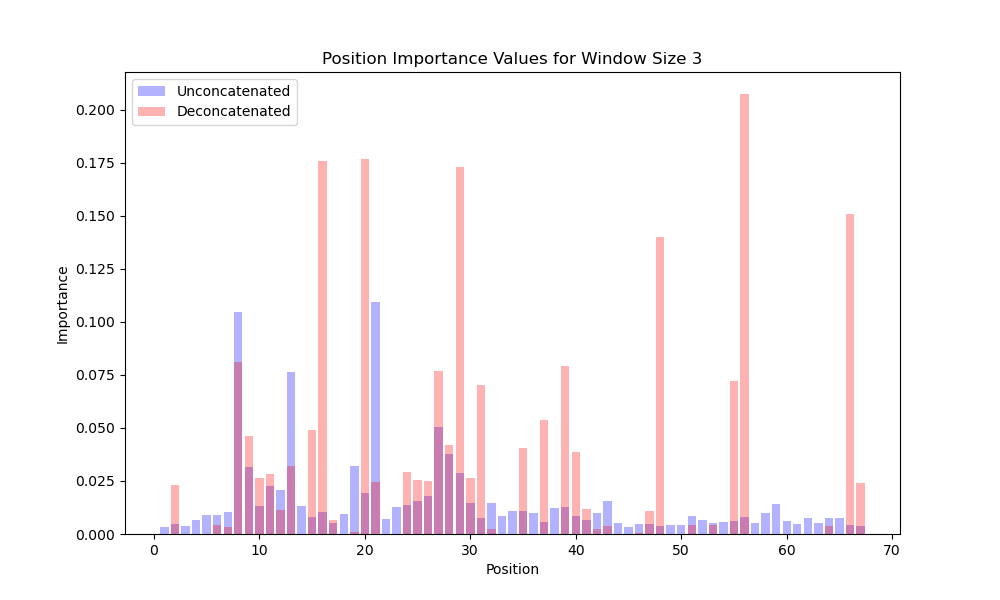

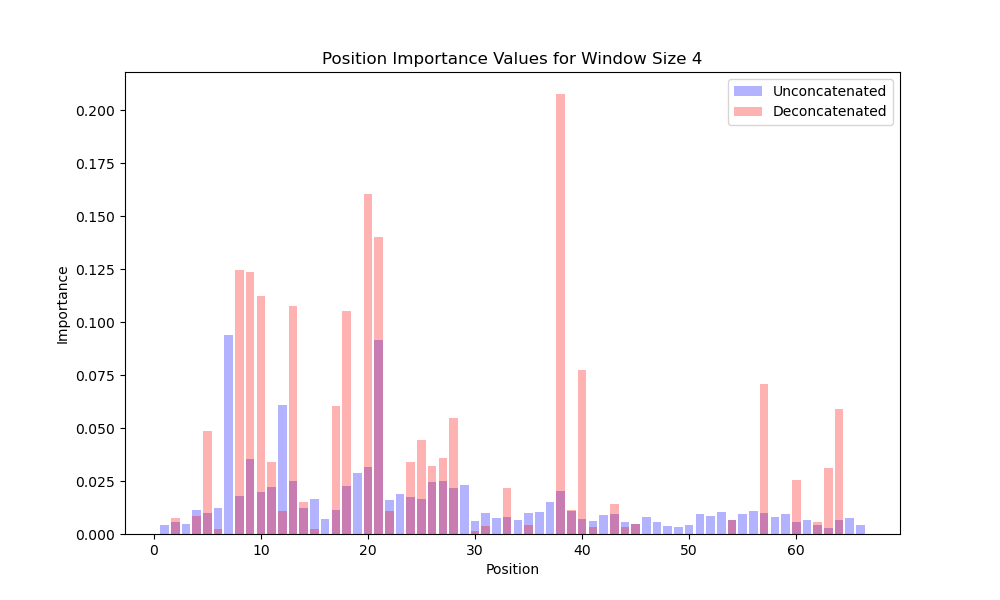

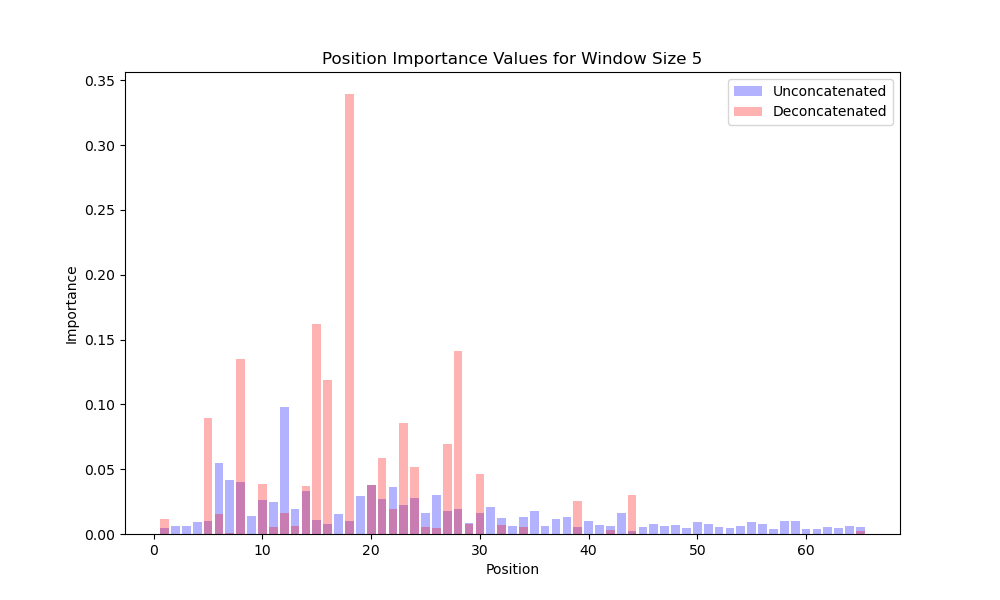

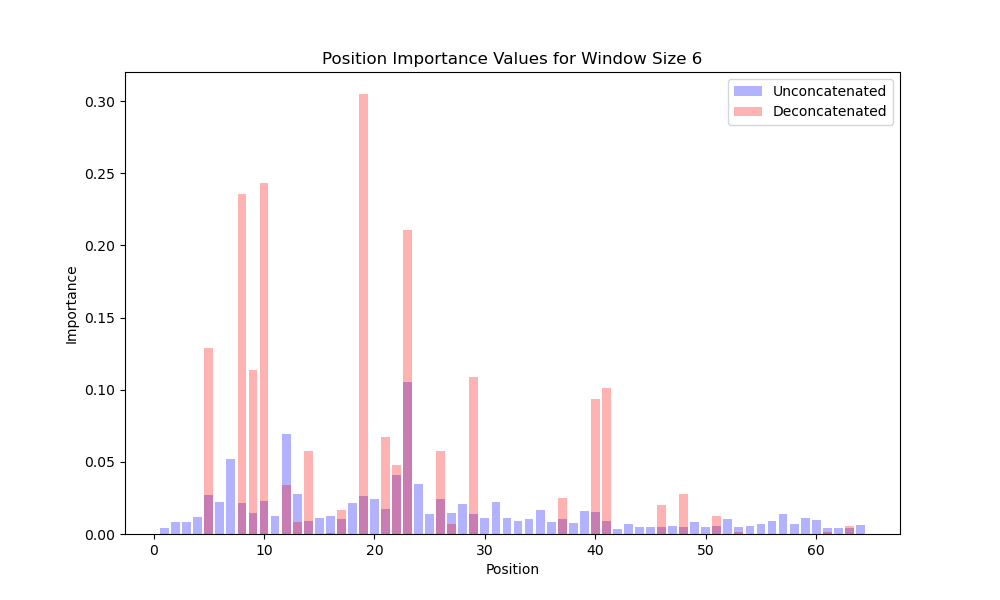

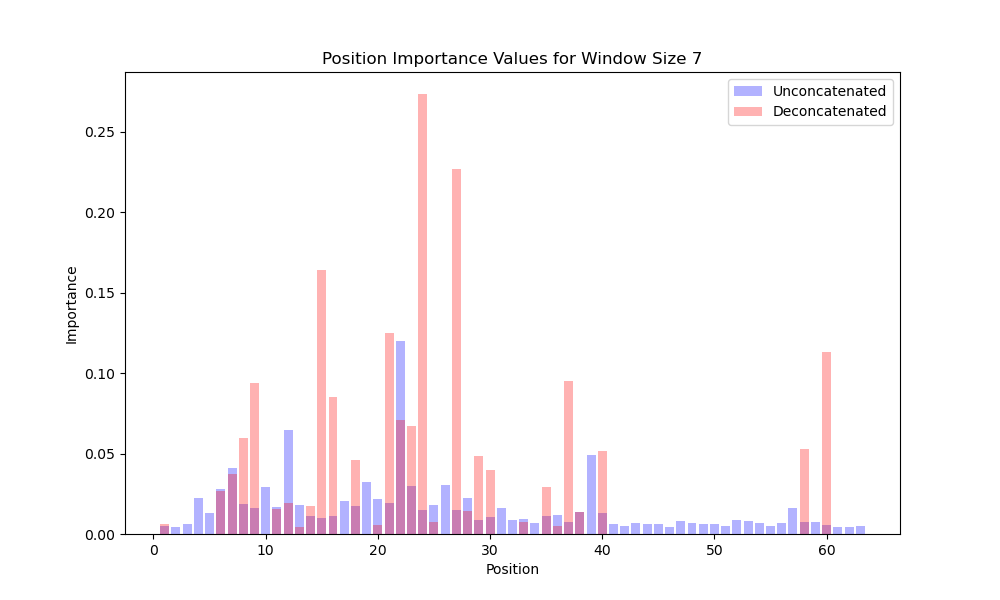

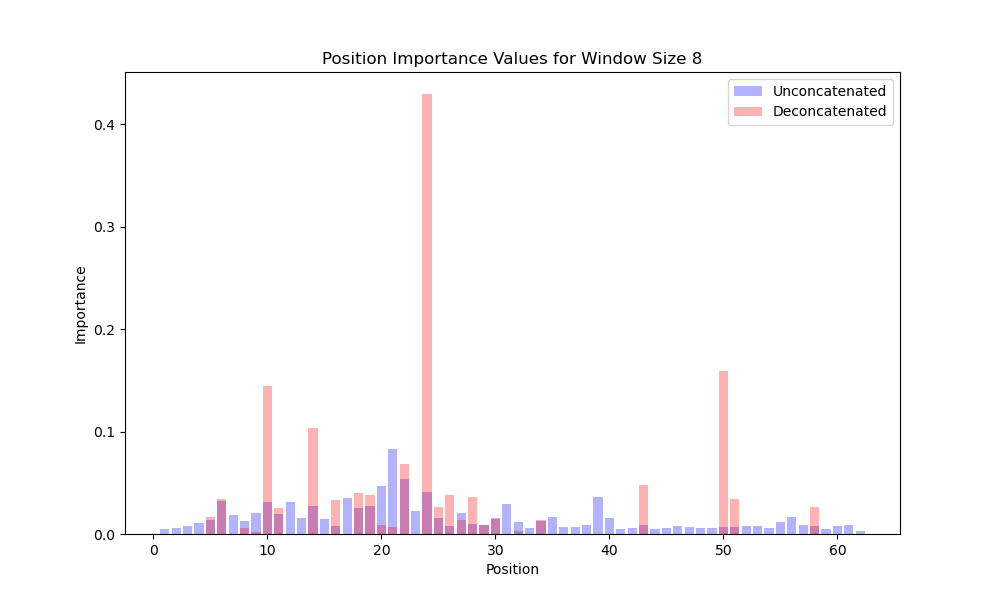

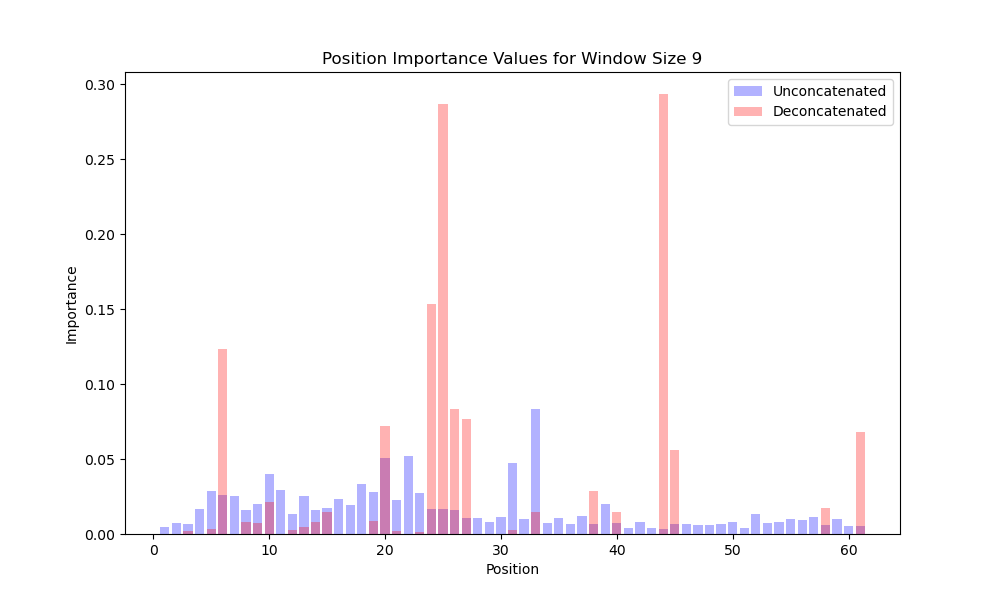

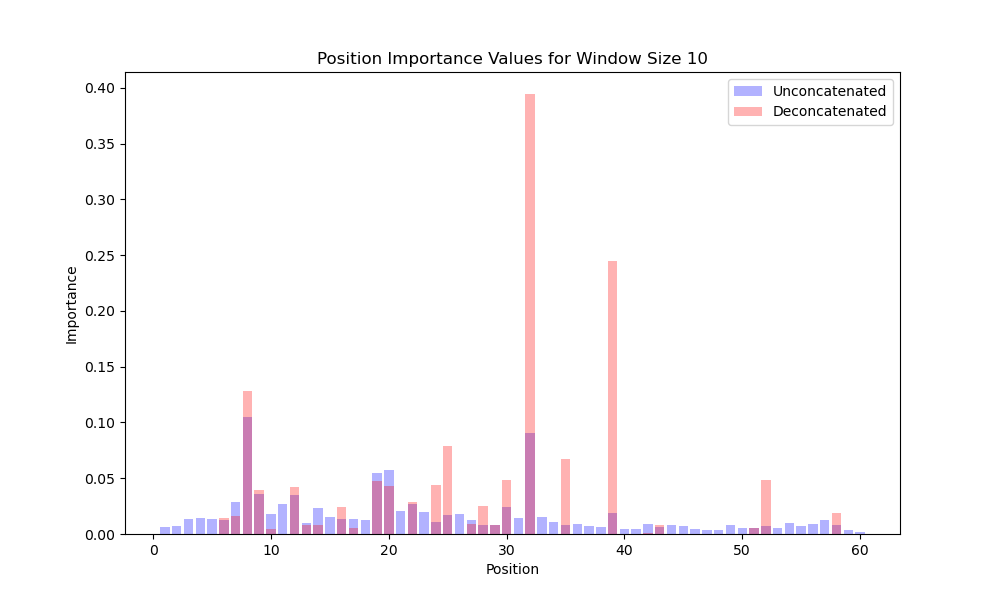

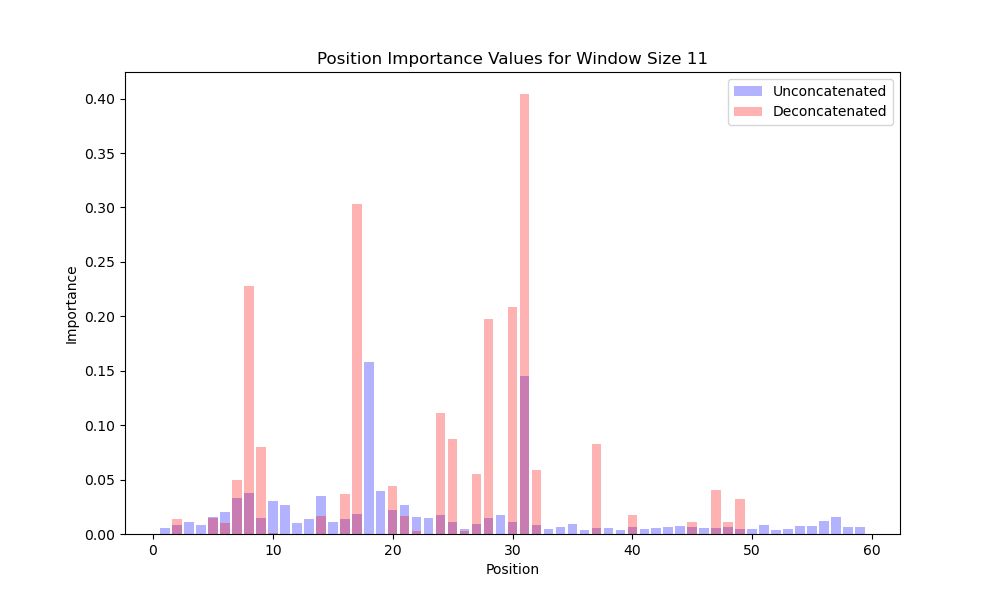

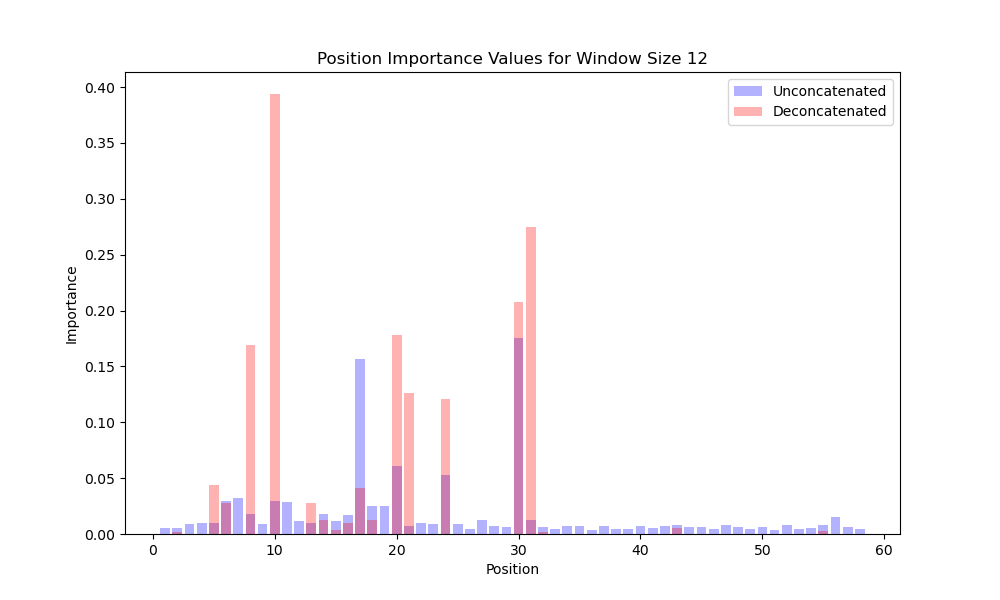

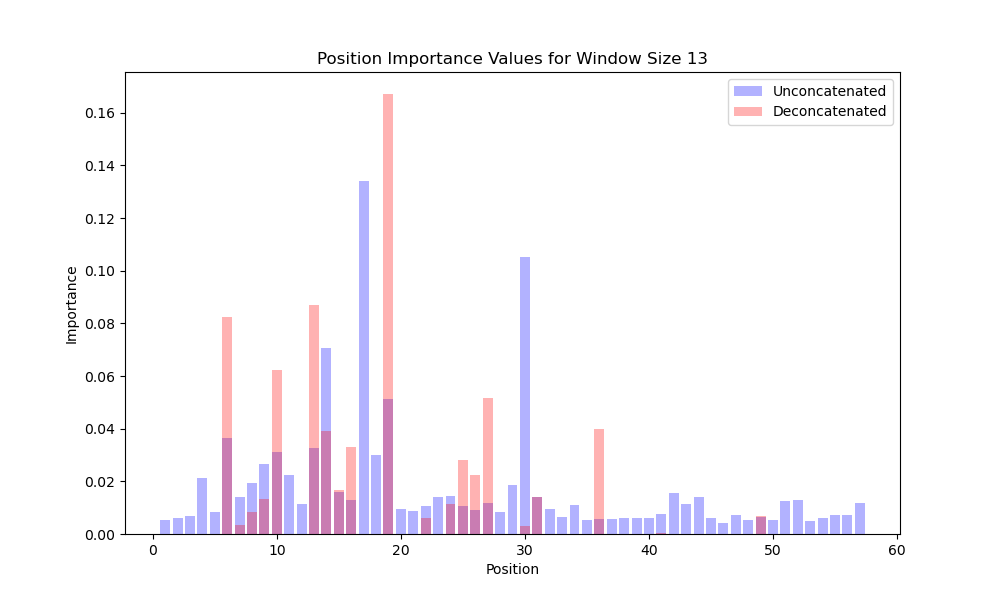

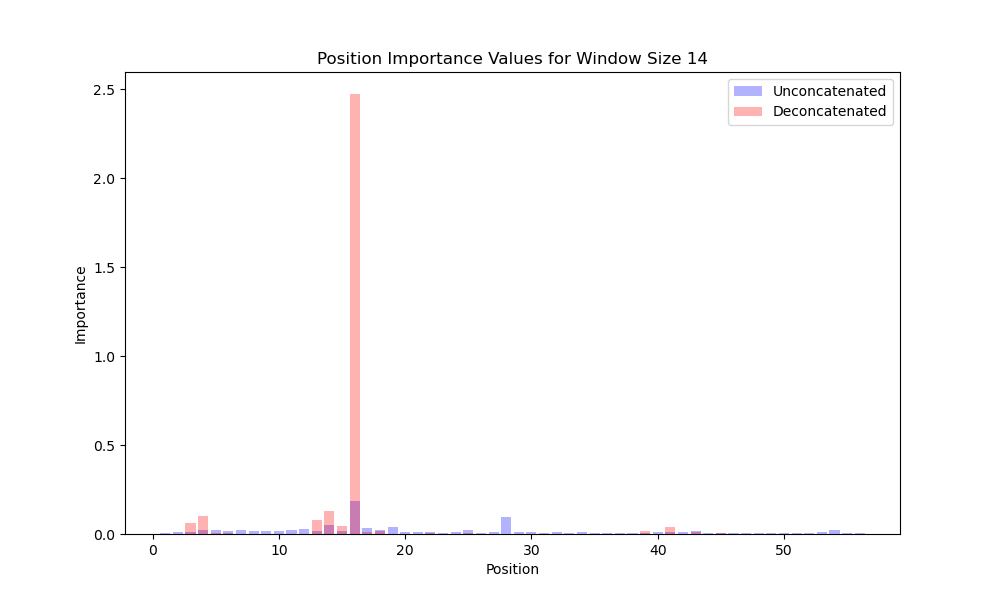

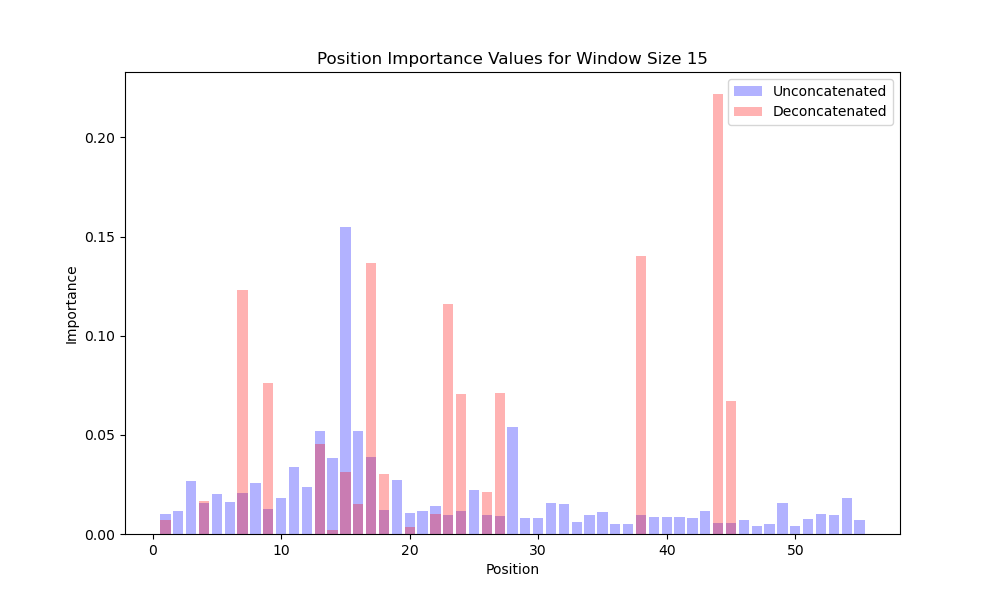

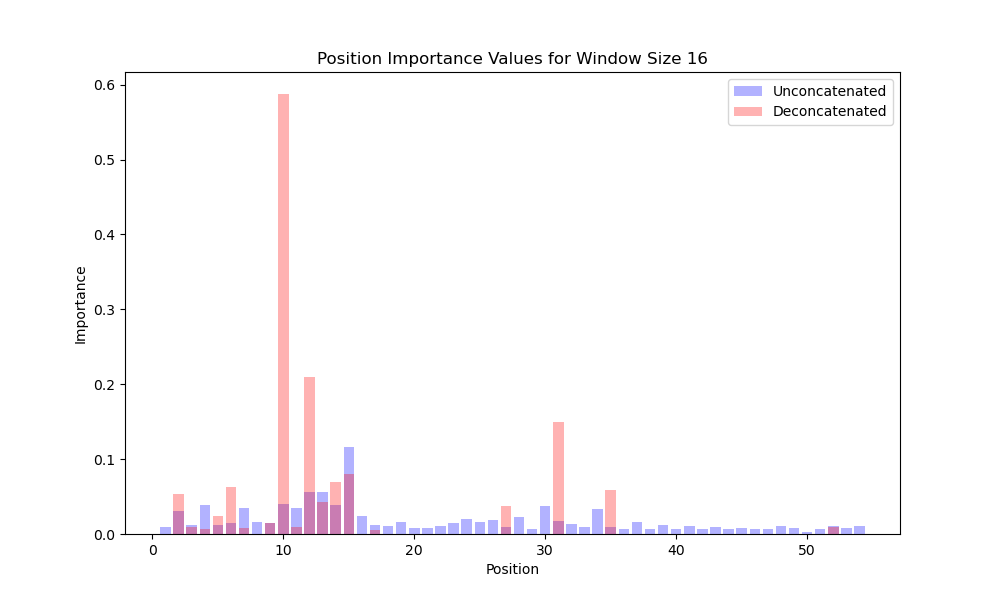

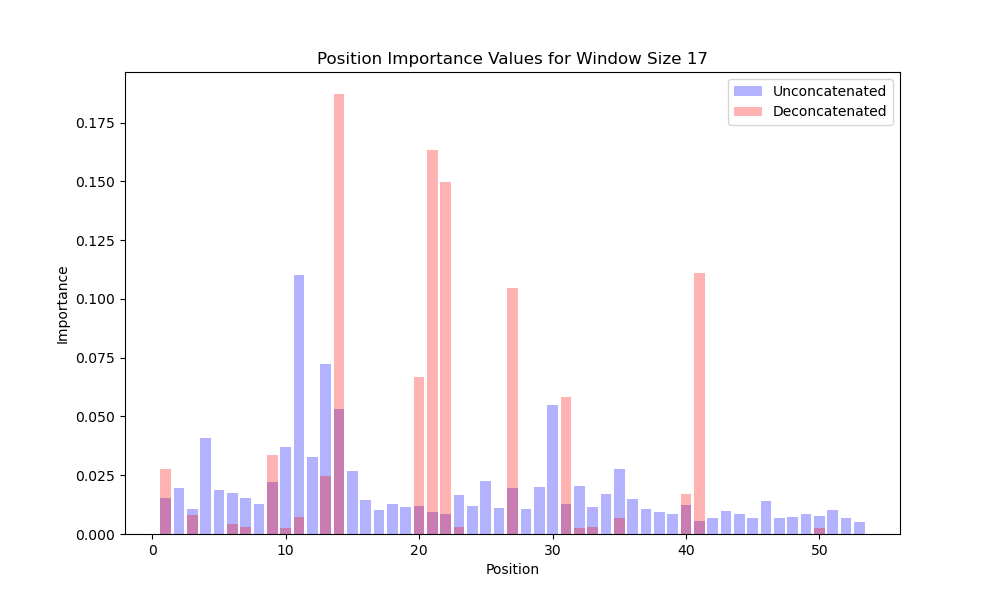

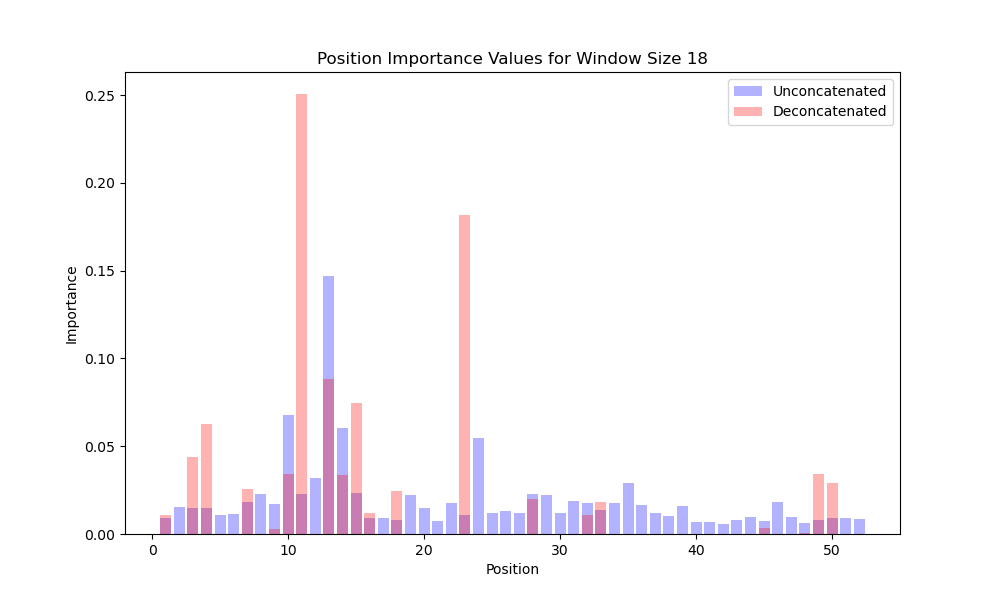

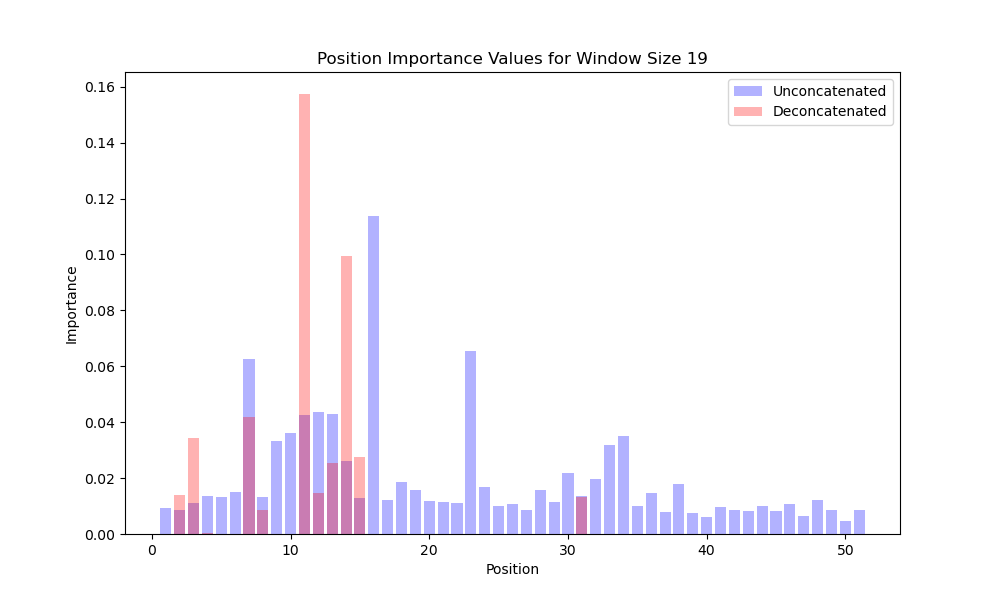

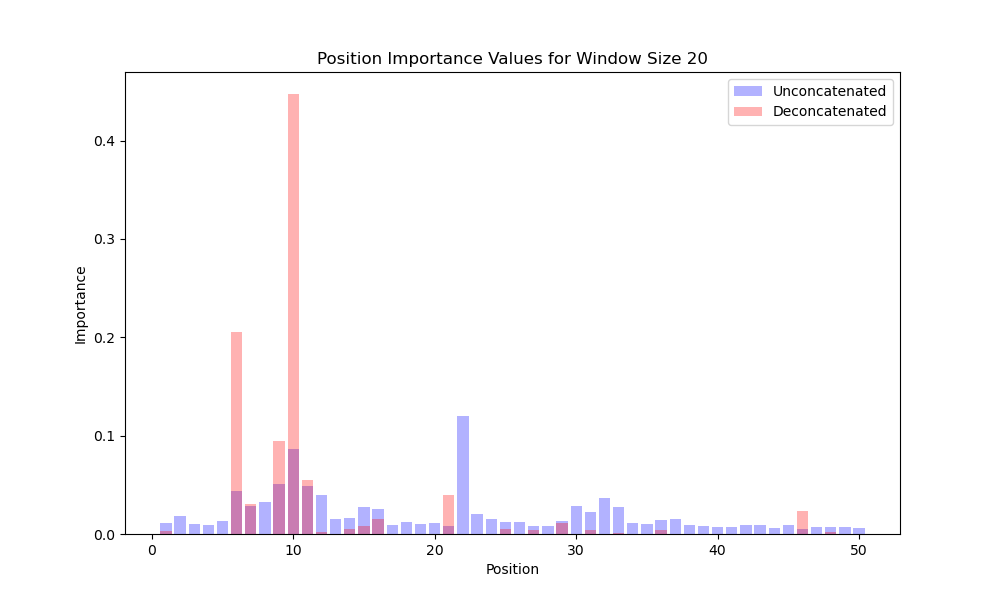

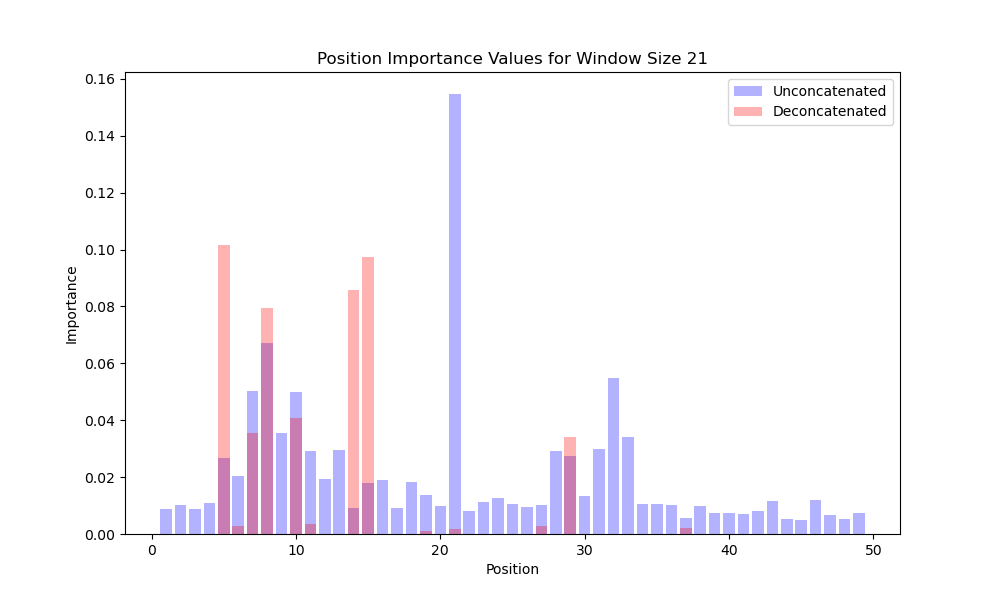

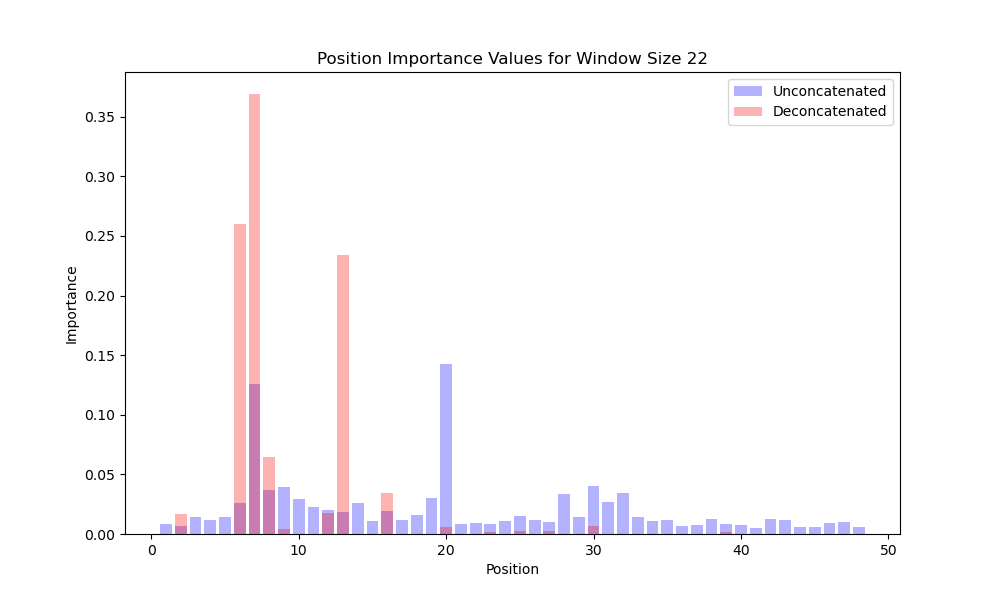

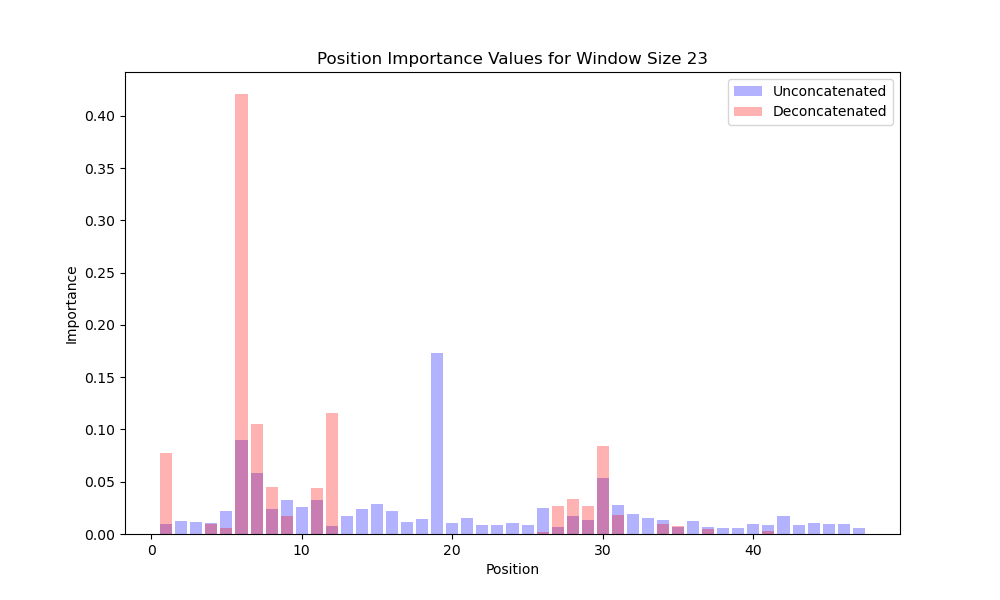

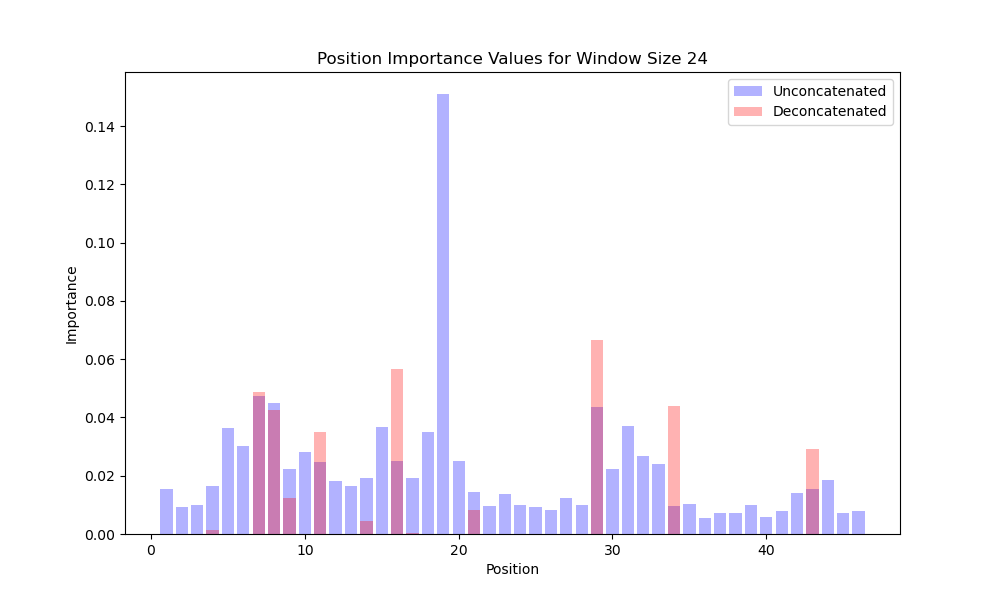

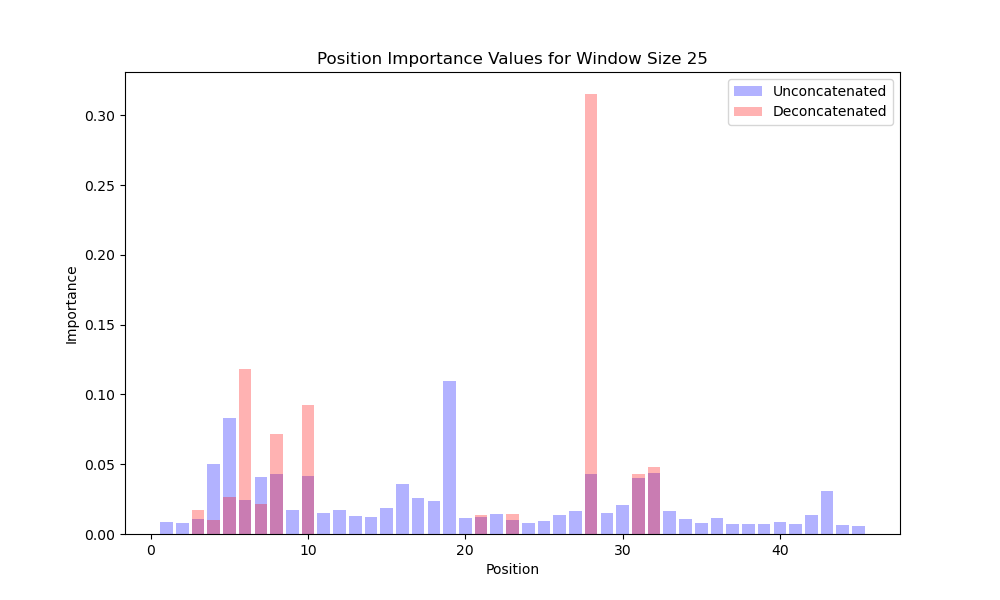

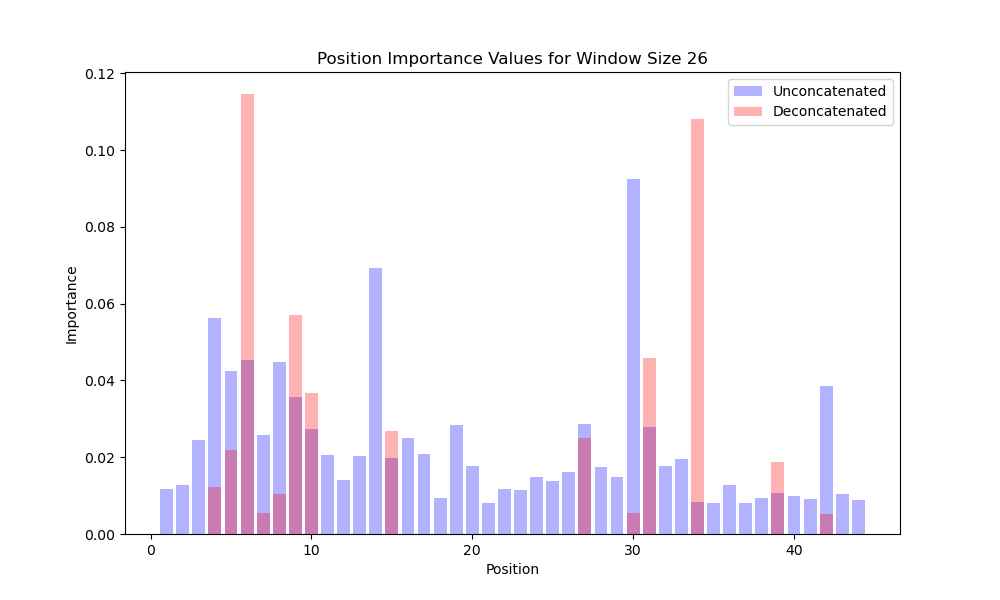

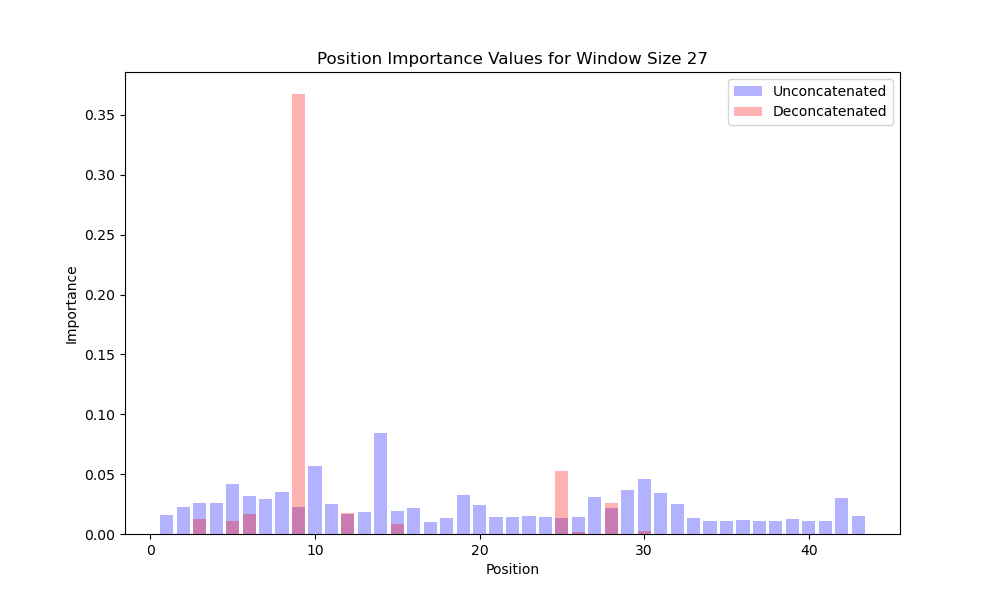

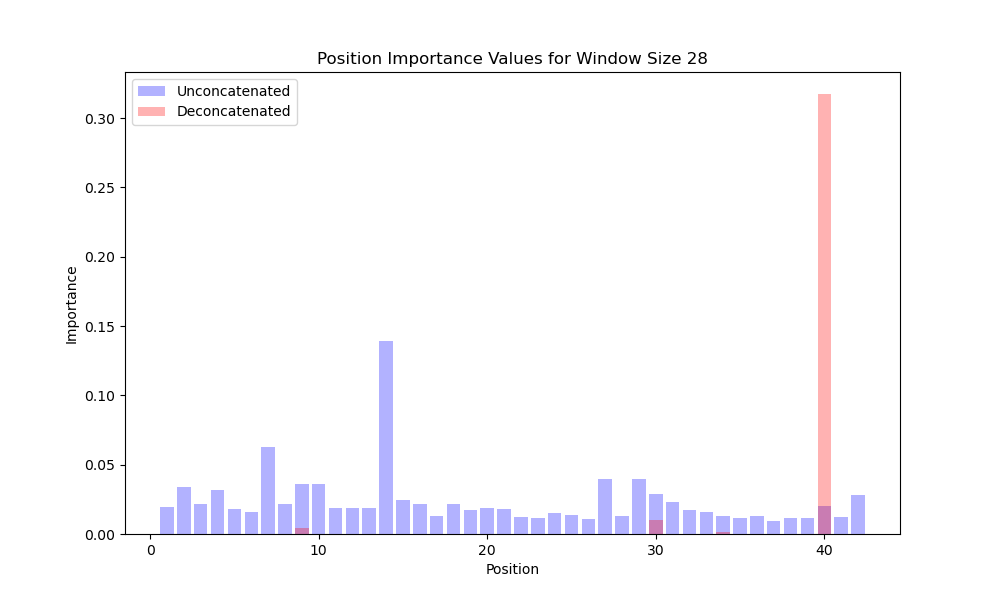

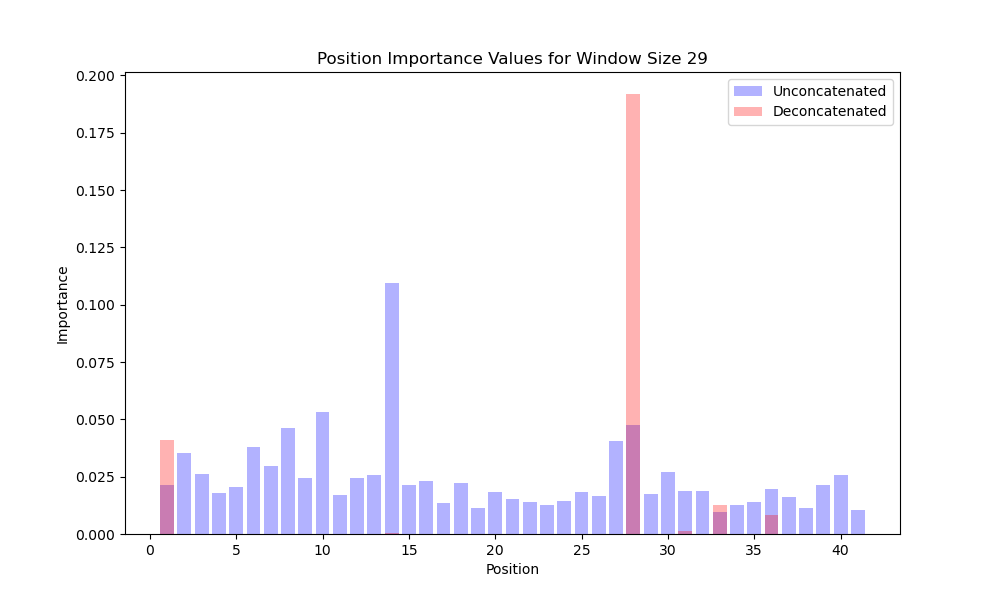

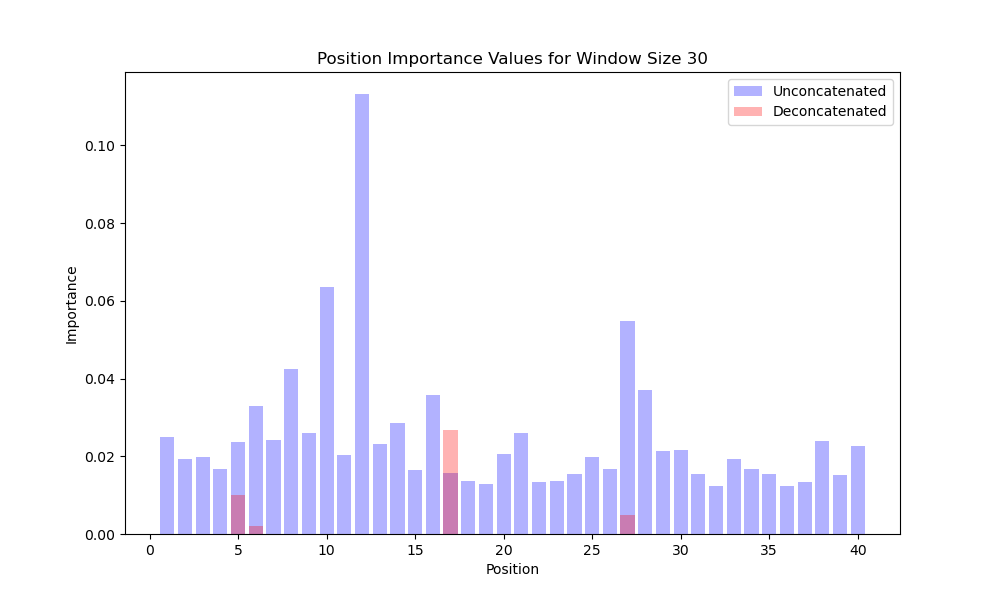

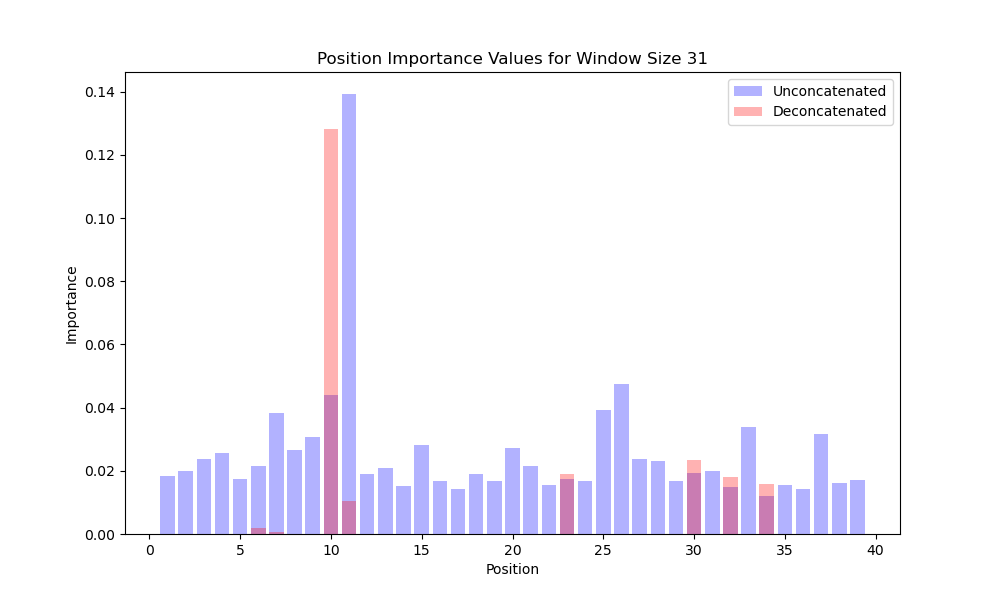

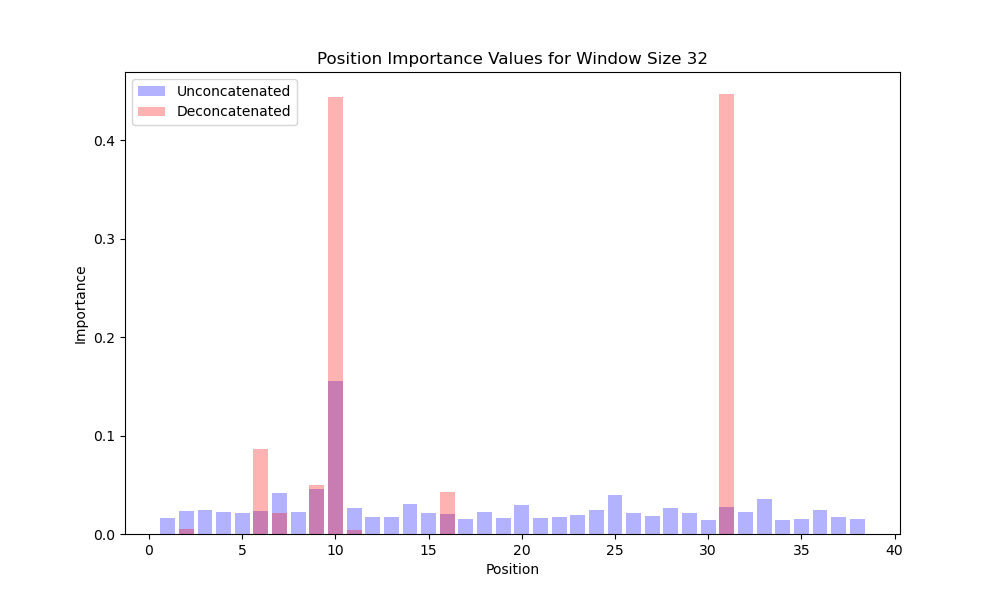

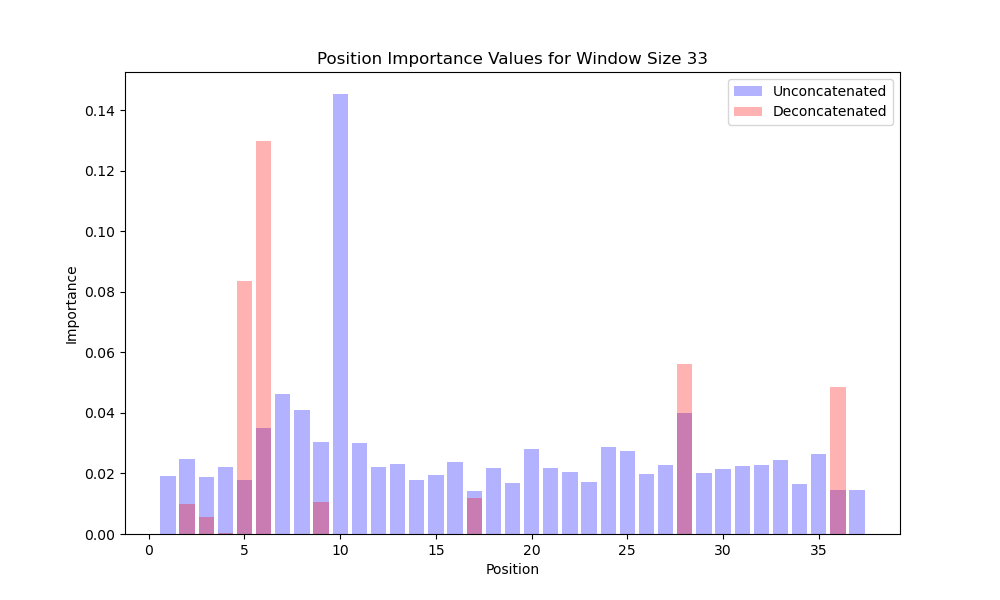

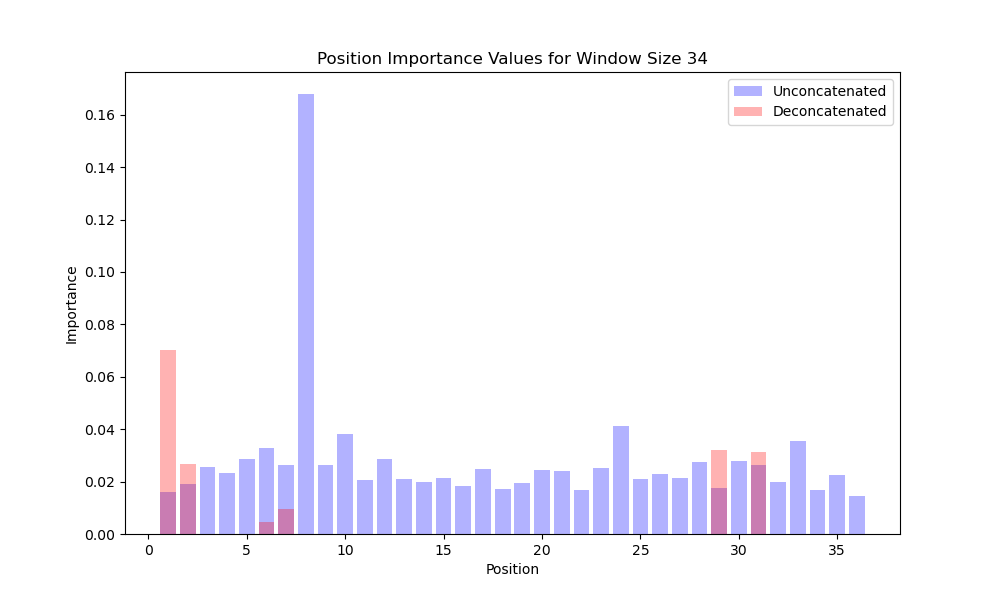

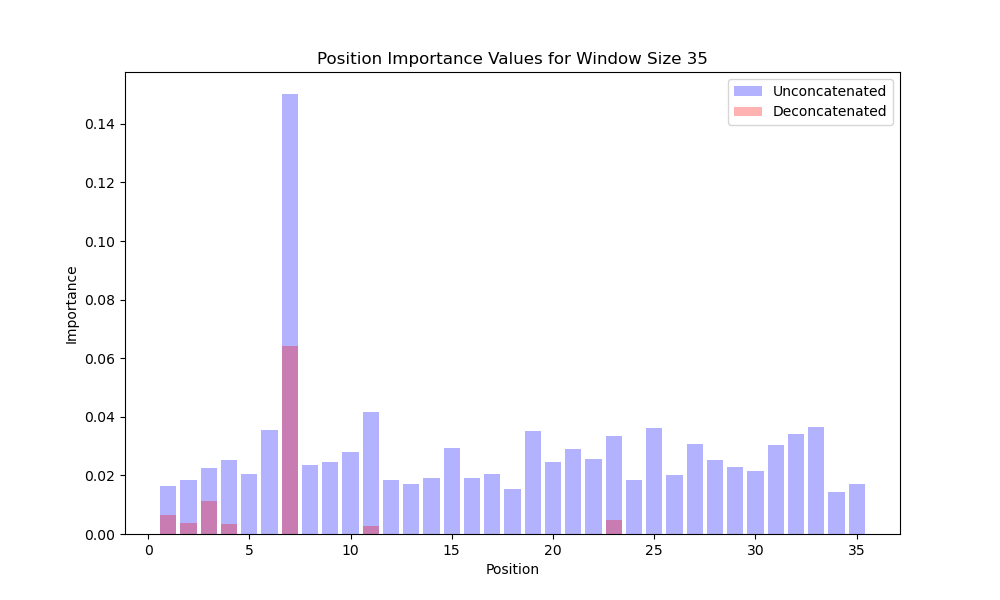

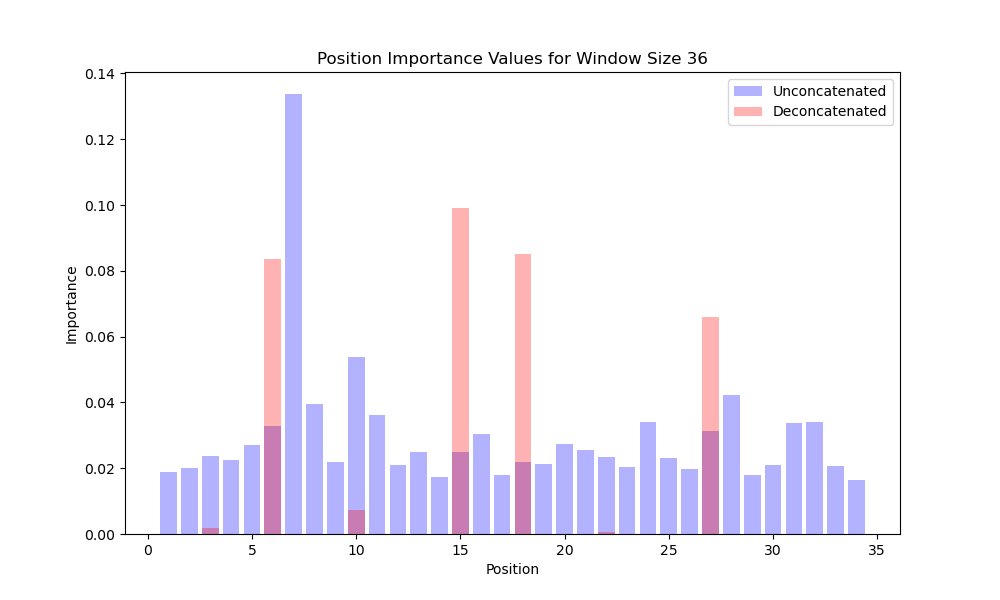

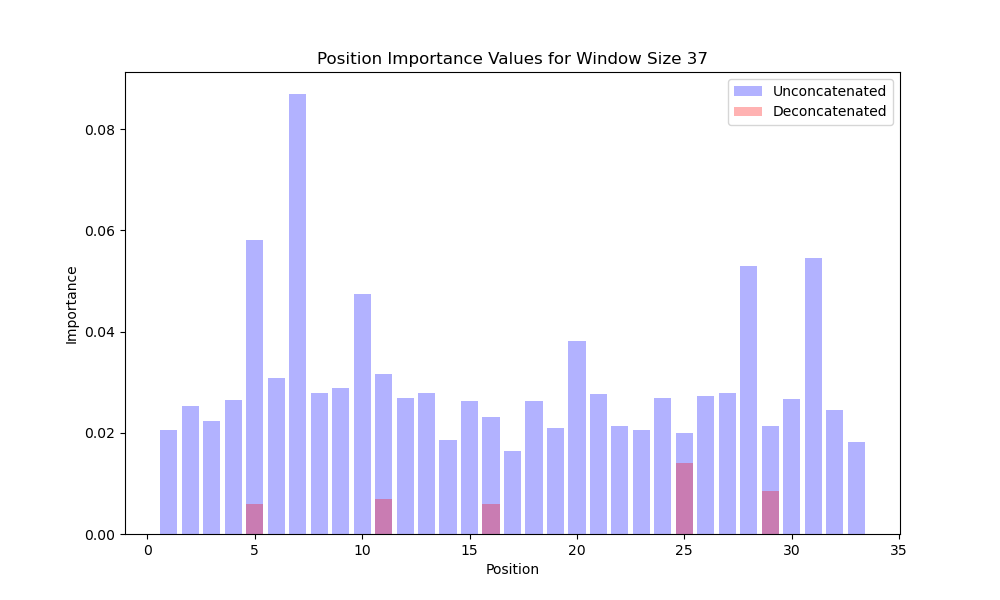

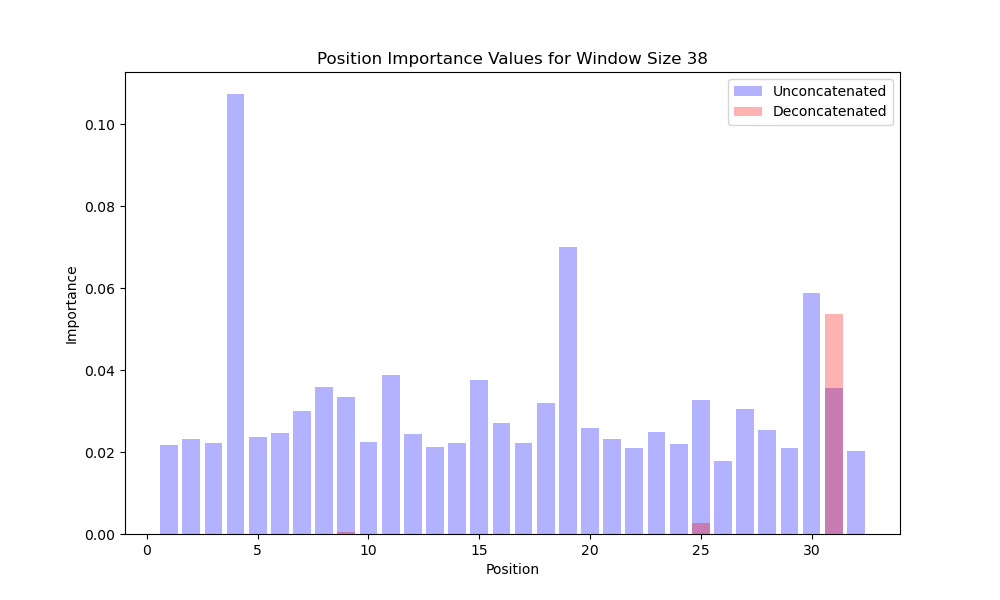

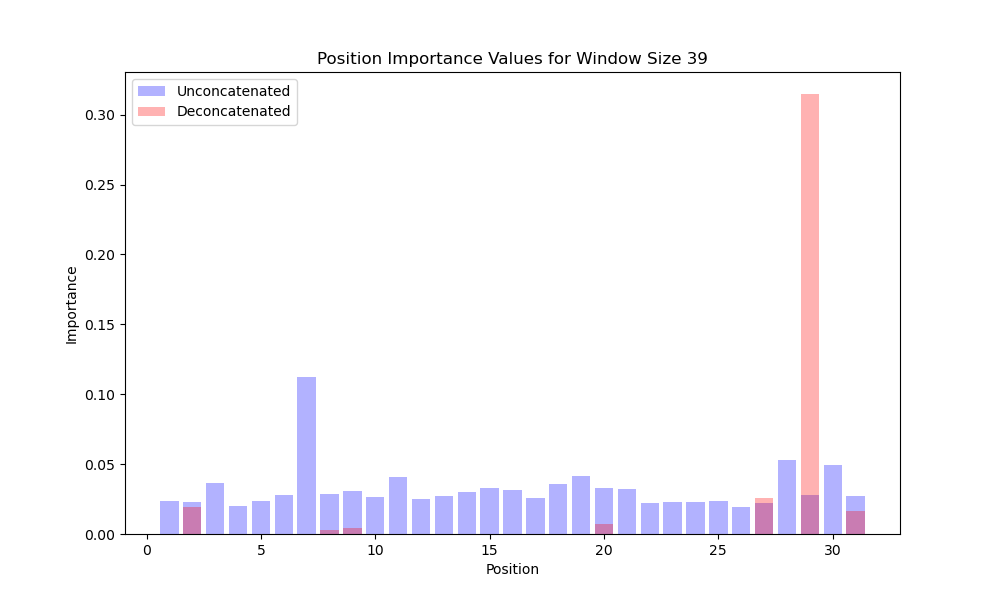

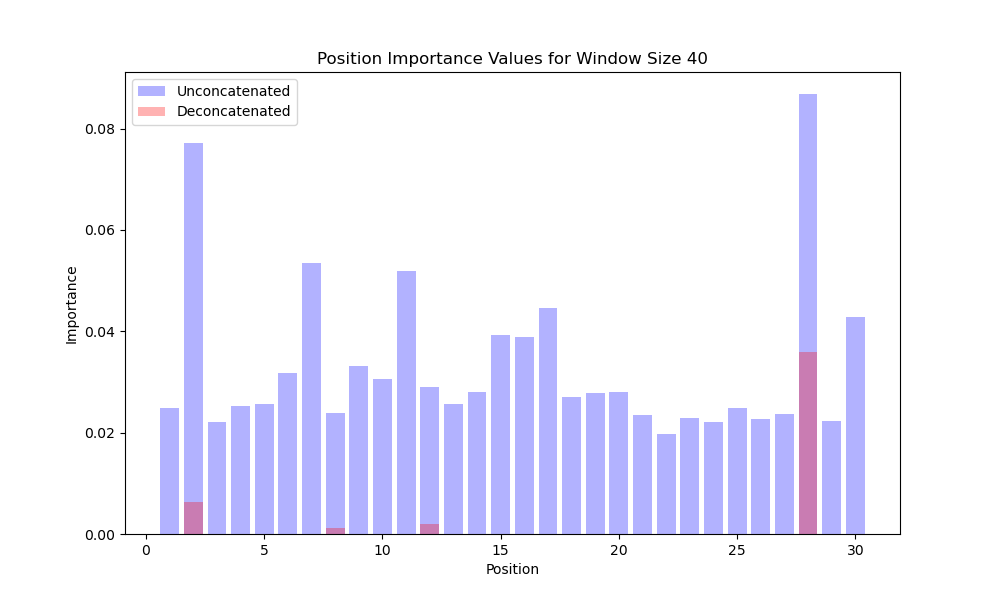

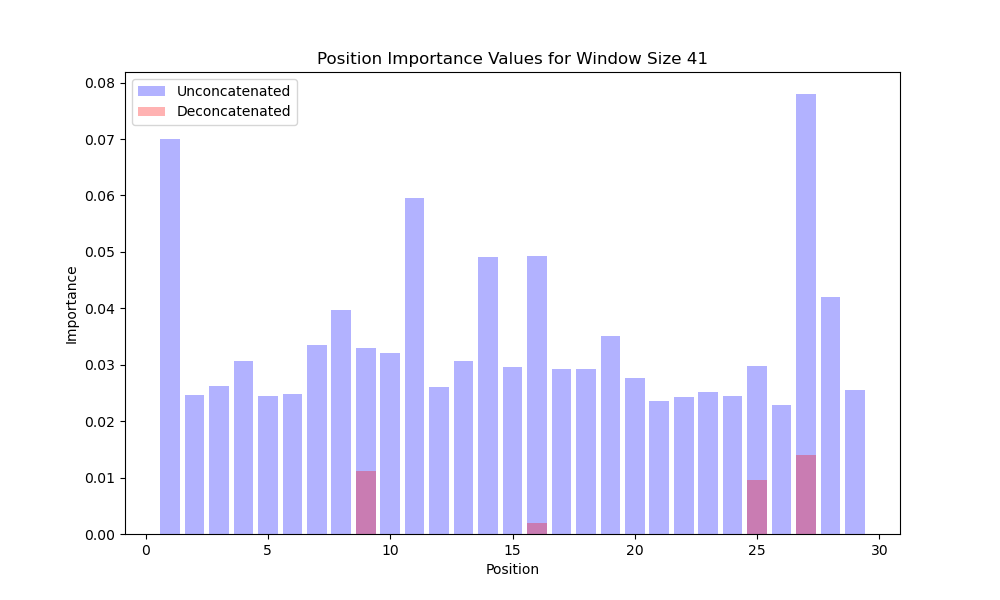

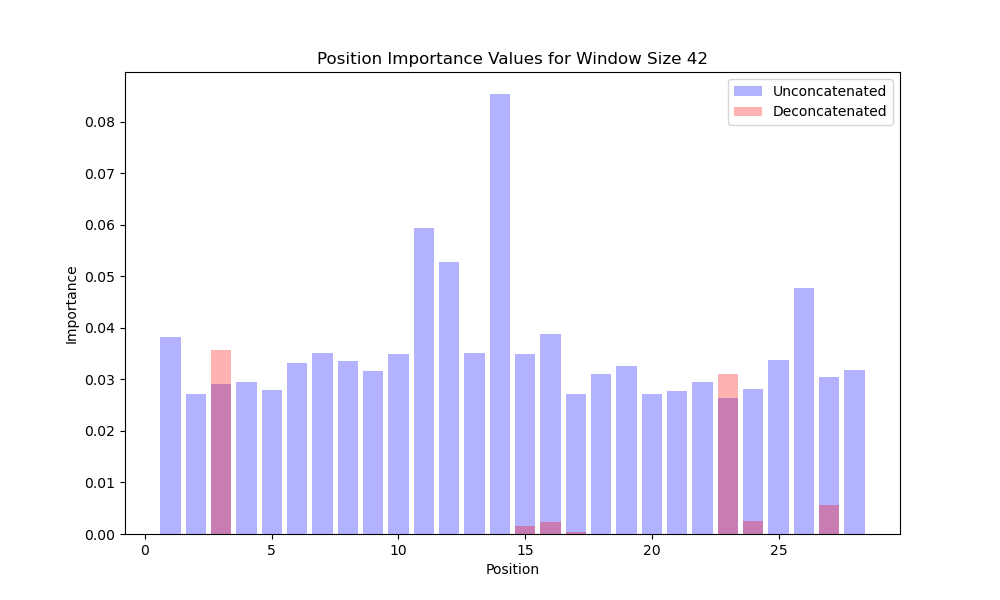

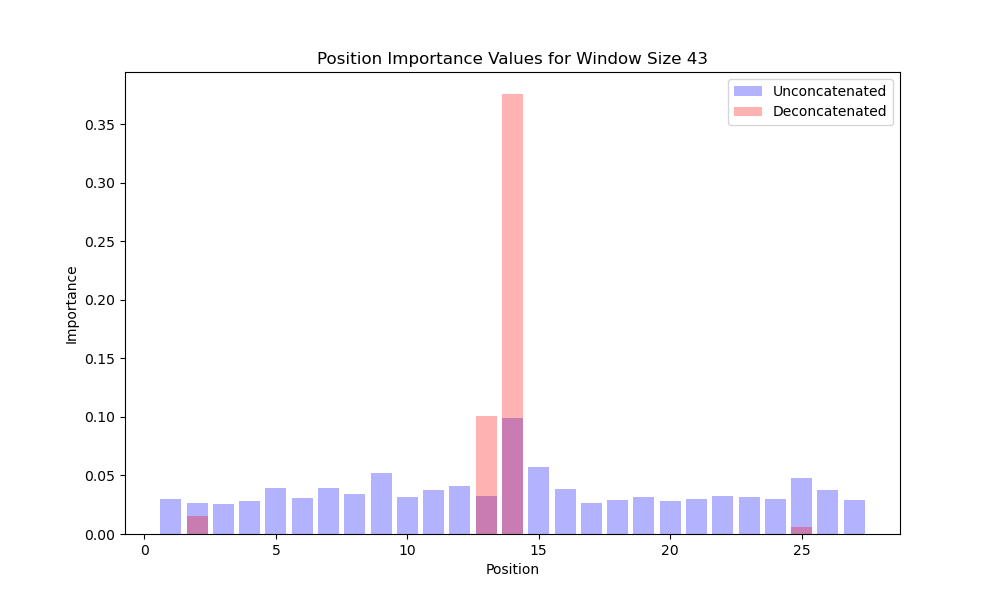

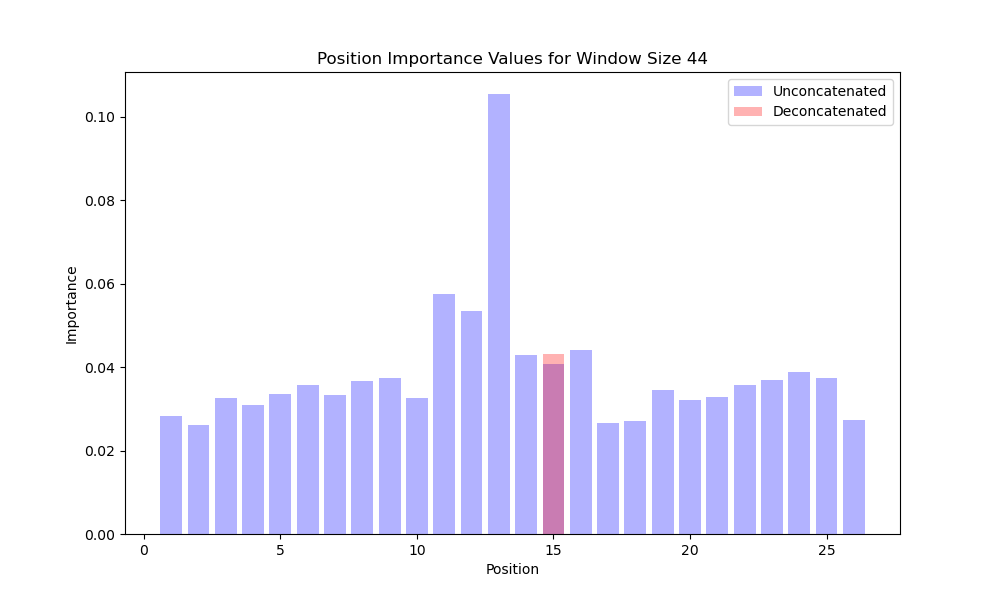

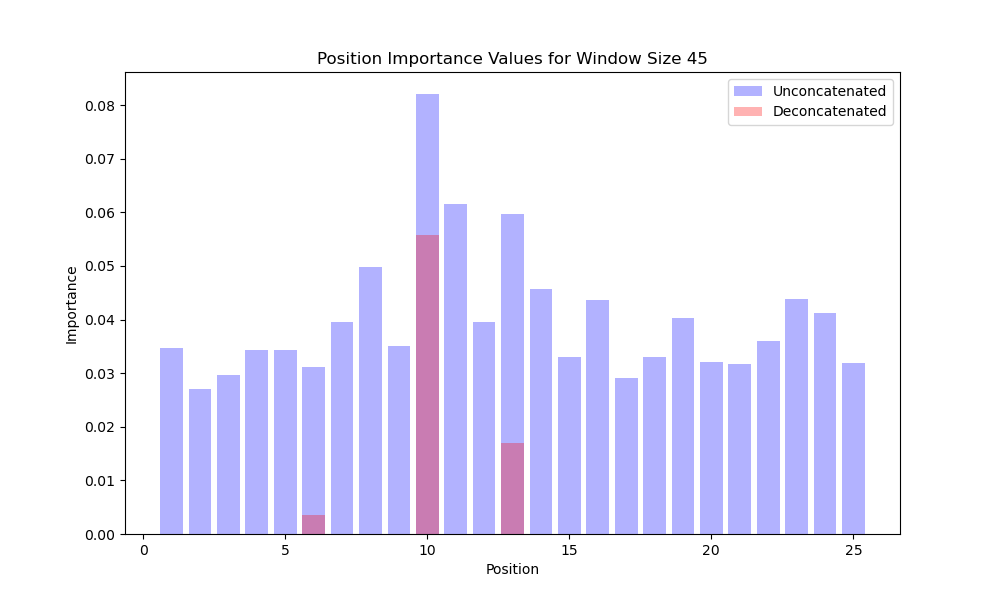

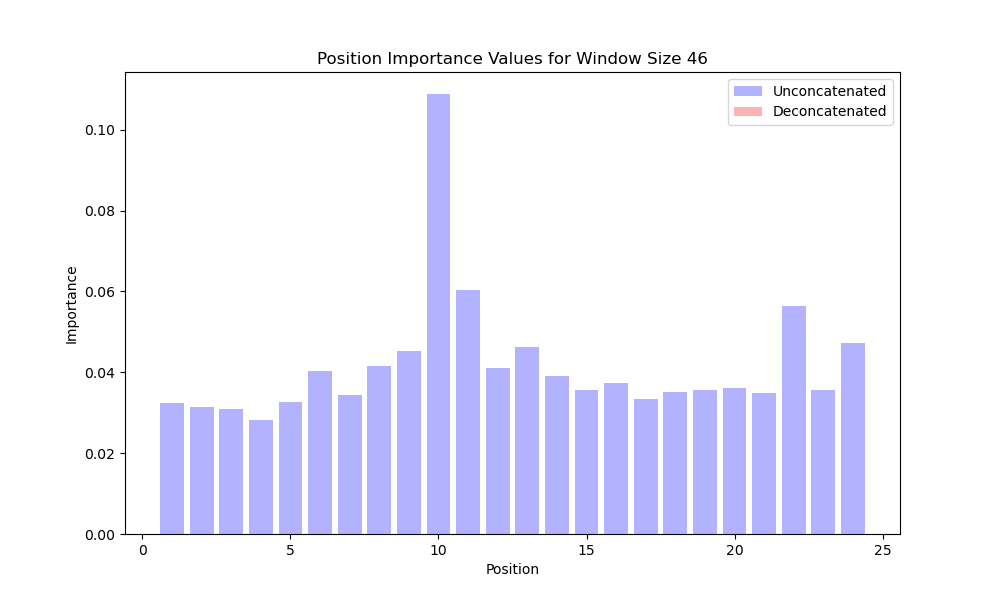

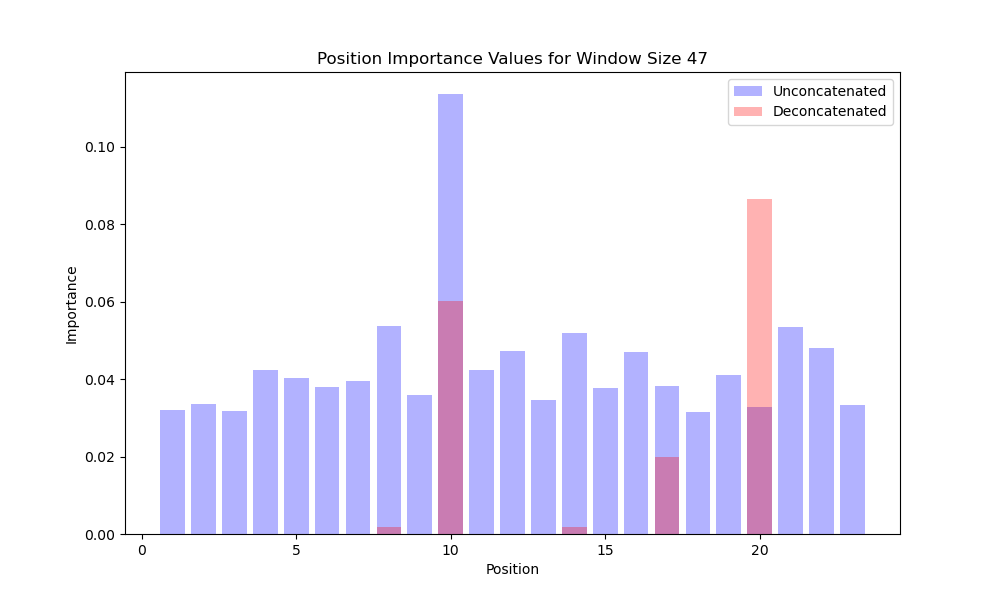

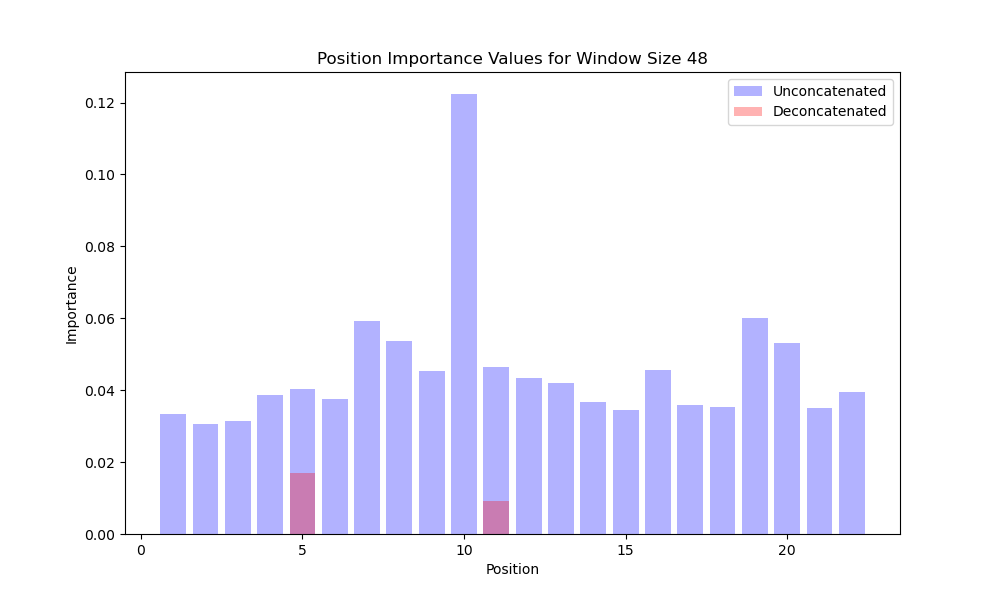

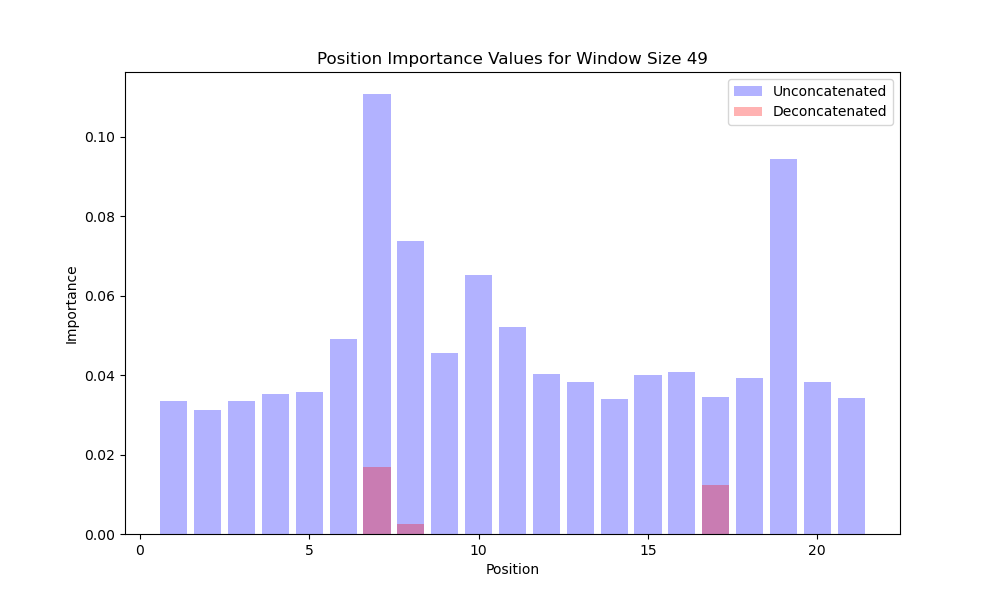

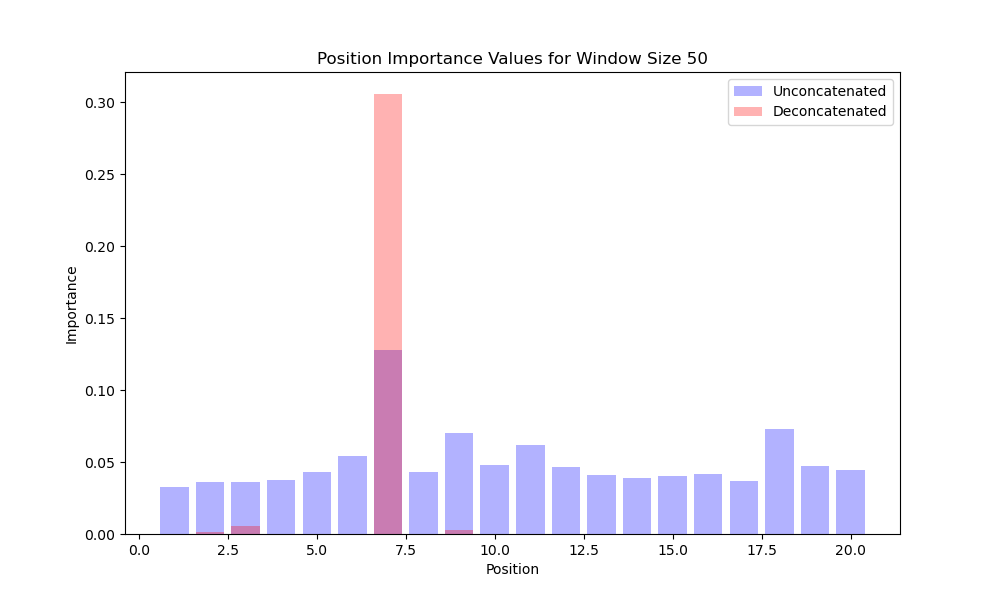

In [12]:
from IPython.display import Image, display
def display_feature_importance_plots(output_folder):
    for window_size in range(2,51):
        image_path = f"{output_folder}/Overlaid_Importance_{window_size}.png"
        display(Image(filename=image_path))
        
display_feature_importance_plots('Overlaid_Importance')